In [1]:
%load_ext rpy2.ipython

# Germline assignment

## Introduction

- Most analyses work at the level of a clonotype
- Identifying what germlines have given rise to a reassorted BCR/TCR is usually the first step in the analysis
- Complicated by:
  - Sequencing error
  - Incomplete reference sequences
  - Evolutionary similarity between alleles in a family
  - Deletions
  - N- and P- nucleotides
  - Somatic hypermutation in the context of BCRs
- Particularly difficult to assign D genes

## Software

- There are an increasing number of software packages for germline assignment
  - Similarity based
    - IgBLAST, IgGraph, IMGT/V-Quest
  - Hidden Markov models
    - iHMMune, partis, repgenHMM
  - Phylogenetic approaches
    - IgSCUEAL

## IgBLAST

- Highly tuned version of the BLAST algorithm for sequence similarity
- Fast
- Reasonably accurate for TCRs and BCRs with low mutational load
  - Less so for highly mutated BCRs

## Reference datasets

- IgBLAST requires a database of germline sequences to compare query sequences to
- IMGT restricts dissemination of germline datasets
  - Usually have to be downloaded separately

## Postprocessing

- IgBLAST does not generate friendly output
- There are a number of postprocessors
  - Machine and human readable tabular output
  - CDR3 region sequences

## Change-O

- Both a *package* and a *format*
- Package:
  - Python package
  - Parses output from IgBLAST IMGT/High-VQuest
  - Also can generate clones, reconstruct germlines
- Format:
  - Simple tabular format
    - Easy to analyse and process
  - Specifies names for particular fields

## Workflow

- Obtain reference sequences
- Generate IgBLAST database
- Convert FASTQ to FASTA
- Run IgBLAST
- Parse the output of IgBLAST
- Generate clones

## Obtaining germline sequences

- Germline sequences can be obtained from IMGT
- Also a community based effort from the AIRR Community
  - Work in progress

## Generating IgBLAST database

In [1]:
%%bash
# V-segment database
perl ./edit_imgt_file.pl IMGT_Human_TRBV.fasta > database/human_trb_v
makeblastdb -parse_seqids -dbtype nucl -in database/human_trb_v



Building a new DB, current time: 10/31/2016 17:09:29
New DB name:   /home/simon/Projects/aairr16-working/slides/database/human_trb_v
New DB title:  database/human_trb_v
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 142 sequences in 0.00876689 seconds.


In [2]:
%%bash
# D-segment database
perl ./edit_imgt_file.pl IMGT_Human_TRBD.fasta > database/human_trb_d
makeblastdb -parse_seqids -dbtype nucl -in database/human_trb_d
# J-segment database
perl ./edit_imgt_file.pl IMGT_Human_TRBJ.fasta > database/human_trb_j
makeblastdb -parse_seqids -dbtype nucl -in database/human_trb_j



Building a new DB, current time: 10/31/2016 17:09:36
New DB name:   /home/simon/Projects/aairr16-working/slides/database/human_trb_d
New DB title:  database/human_trb_d
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 3 sequences in 0.000468016 seconds.


Building a new DB, current time: 10/31/2016 17:09:36
New DB name:   /home/simon/Projects/aairr16-working/slides/database/human_trb_j
New DB title:  database/human_trb_j
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.000876904 seconds.


## Convert FASTQ to FASTA

- Most pipelines keep sequence data in FASTQ format, but IgBLAST takes FASTA
- This little Biopython snippet converts FASTQ to FASTA

In [31]:
from copy import deepcopy
from Bio import SeqIO
inhandle = open("A2-i131.fastq",'r')
outhandle = open("A2-i131_reheader.fastq",'w')
for record in SeqIO.parse(inhandle,"fastq"):
    newr = deepcopy(record)
    newr.id=newr.description.replace("MIG UMI:","")
    newr.id=newr.id.replace(":","|CONSCOUNT=")
    newr.description=""
    newr.name=""
    SeqIO.write(newr,outhandle,"fastq")
inhandle.close()
outhandle.close()

In [32]:
!head A2-i131_reheader.fastq

@GTCATTTAGCATGCTG|CONSCOUNT=2
TCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTAGAGGGGTACACTGAAGCTTTCTTTGGACAAGGCACCAGACTCAC
+
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
@TTGCGTTCGTTCTAAT|CONSCOUNT=3
TGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCTGCAGCGTCGTTACTAAGGACAGGGAAGAGACCCAGTACTTCGGGCCAGGCACGCGGCTCCT
+
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
@TATAATATCGTAACGT|CONSCOUNT=7
GATCCAGCCTGCAAAGCTTGAGGACTCGGCCGTGTATCTCTGTGCCAGCAGCTCCGGATACACCGGGGAGCTGTTTTTTGGAGAAGGCTCTAGGCTGACC


In [45]:
!CollapseSeq.py -s A2-i131_reheader.fastq -n 20 --inner \
    --cf CONSCOUNT --act sum --outname A2-i131

       START> CollapseSeq
        FILE> A2-i131_reheader.fastq
 MAX_MISSING> 20
 UNIQ_FIELDS> None
 COPY_FIELDS> CONSCOUNT
COPY_ACTIONS> sum
   MAX_FIELD> None
   MIN_FIELD> None
       INNER> True
KEEP_MISSING> False

MISSING>  0
PROGRESS> 10:48:40 [####################] 100% (429,994) 0.1 min

      OUTPUT> A2-i131_collapse-unique.fastq
   SEQUENCES> 429994
      UNIQUE> 332480
   DUPLICATE> 97514
UNDETERMINED> 0
         END> CollapseSeq



In [46]:
from Bio import SeqIO
SeqIO.convert("A2-i131_collapse-unique.fastq","fastq","A2-i131.fasta","fasta")

332480

## Running IgBLAST

- A custom output format is chosen to allow parsing with Change-O

In [47]:
%%bash
igblastn \
    -germline_db_V database/human_trb_v \
    -germline_db_D database/human_trb_d \
    -germline_db_J database/human_trb_j \
    -auxiliary_data optional_file/human_gl.aux \
    -domain_system imgt -ig_seqtype TCR -organism human \
    -outfmt '7 std qseq sseq btop' \
    -query A2-i131.fasta \
    -out A2-i131.fmt7 \
    -num_threads 3

## Postprocess BLAST

In [3]:
%%bash
MakeDb.py igblast -i A2-i131.fmt7 -s A2-i131.fasta -r IMGT_Human_TRB[VDJ].fasta \
    --regions --scores

        START> MakeDB
      ALIGNER> IgBlast
ALIGN_RESULTS> A2-i131.fmt7
     SEQ_FILE> A2-i131.fasta
     NO_PARSE> False
 SCORE_FIELDS> True
REGION_FIELDS> True

PROGRESS> 14:58:56 [####################] 100% (332,480) 30.8 min

OUTPUT> A2-i131_db-pass.tab
  PASS> 321568
  FAIL> 10912
   END> MakeDb



## Defining clones

In [43]:
%%R
library(ggplot2)
library(alakazam)
library(shazam)

In [ ]:
%%R
db <- readChangeoDb("A2-i131_db-pass.tab")
db <- distToNearest(db, model="ham", symmetry="min")

Read 407100 rows and 47 (of 47) columns from 0.438 GB file in 00:00:04


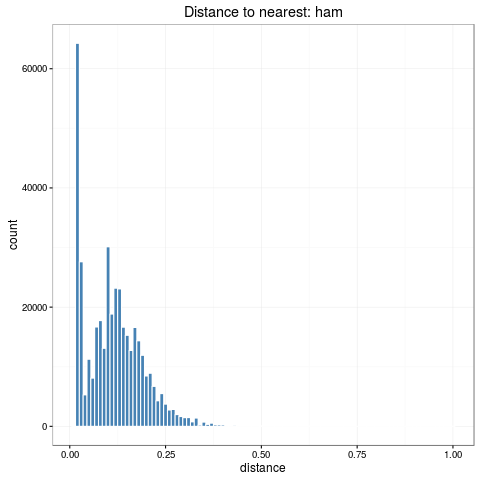

In [48]:
%%R
p1 <- ggplot() + theme_bw() + 
    ggtitle("Distance to nearest: ham") + xlab("distance") +
    geom_histogram(data=db, aes(x=DIST_NEAREST), binwidth=0.01, 
                   fill="steelblue", color="white")
plot(p1)

## Defining clones

In [1]:
%%bash
DefineClones.py bygroup -d A2-i131_db-pass.tab --act set --model ham \
--sym min --norm len --dist 0.01

     START> DefineClones
   DB_FILE> A2-i131_db-pass.tab
GROUP_FUNC> indexJunctions
GROUP_ARGS> {'fields': None, 'mode': 'gene', 'action': 'set'}
CLONE_FUNC> distanceClones
CLONE_ARGS> {'model': 'ham', 'linkage': 'single', 'sym': 'min', 'seq_field': 'JUNCTION', 'norm': 'len', 'distance': 0.01}
     NPROC> 4

PROGRESS> Grouping sequences
PROGRESS> 23:03:31 (321568) 10.3 min

PROGRESS> Assigning clones
PROGRESS> 13:09:31 [####################] 100% (321,568) 855.8 min

 OUTPUT> A2-i131_db-pass_clone-pass.tab
 CLONES> 285704
RECORDS> 321568
   PASS> 321568
   FAIL> 0
    END> DefineClones

